In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
from transformers import pipeline

In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("dylanjcastillo/7k-books-with-metadata")

print("Path to dataset files:", path)

Using Colab cache for faster access to the '7k-books-with-metadata' dataset.
Path to dataset files: /kaggle/input/7k-books-with-metadata


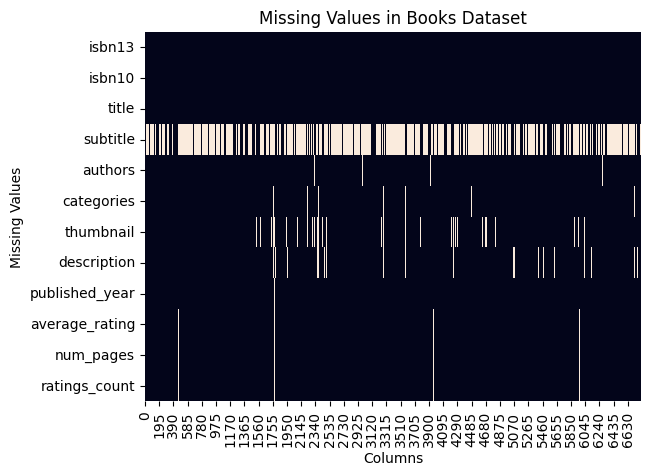

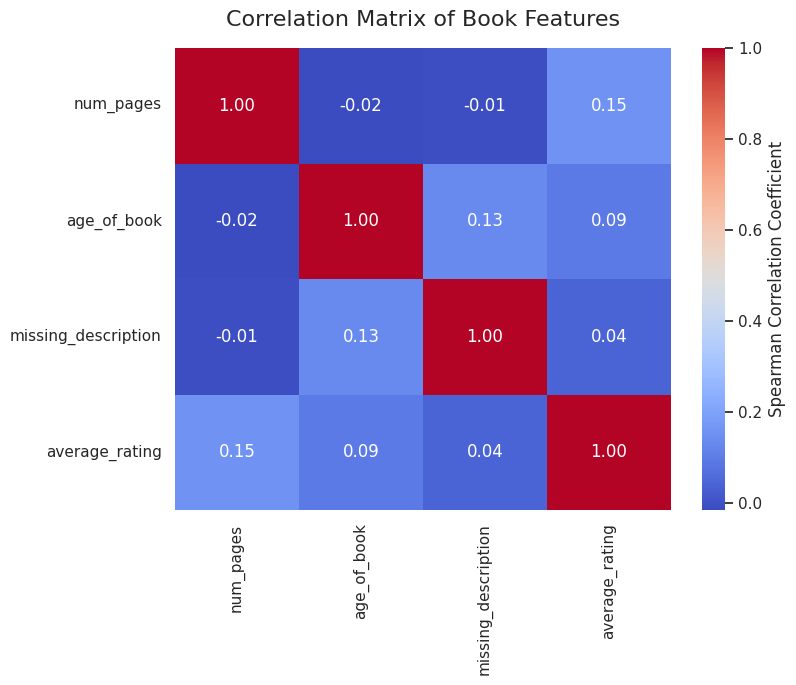

/tmp/ipython-input-147510688.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  book_missing["words_in_description"] = book_missing["description"].str.split().str.len()
/tmp/ipython-input-147510688.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  book_missing_25_words["title_and_subtitle"] = ( np.where(book_missing_25_words["subtitle"].isna(), book_missing_25_words["title"], book_missing_25_words[["title", "subtitle"]].astype(str).agg(": ".join, axis = 1 ) ))
/tmp/ipython-input-147510688.py:37: Settin

             isbn13      isbn10  \
0     9780002005883  0002005883   
1     9780002261982  0002261987   
3     9780006178736  0006178731   
4     9780006280897  0006280897   
5     9780006280934  0006280935   
...             ...         ...   
6802  9788172235222  8172235224   
6803  9788173031014  8173031010   
6804  9788179921623  817992162X   
6805  9788185300535  8185300534   
6808  9789027712059  9027712050   

                                                  title  \
0                                                Gilead   
1                                          Spider's Web   
3                                        Rage of angels   
4                                        The Four Loves   
5                                   The Problem of Pain   
...                                                 ...   
6802                                  Mistaken Identity   
6803                                Journey to the East   
6804  The Monk Who Sold His Ferrari: A Fable Abo

In [5]:
# Dataset loading, review, and preprocessing steps

books = pd.read_csv(f"{path}/books.csv")
# print(books.head())

ax = plt.axes()
sns.heatmap(books.isna().transpose(), cbar = False, ax = ax)
plt.xlabel("Columns")
plt.ylabel("Missing Values")
plt.title("Missing Values in Books Dataset")
plt.show()

books["missing_description"] = np.where(books["description"].isna(), 1, 0)
books["age_of_book"]         = 2024 - books["published_year"]

coloumns_of_interest = ["num_pages", "age_of_book", "missing_description", "average_rating"]
correlation_matrix   = books[coloumns_of_interest].corr(method = "spearman")

sns.set_theme(style = "white")
plt.figure(figsize = (8, 6))
heatmap  = sns.heatmap(correlation_matrix, annot = True, fmt = ".2f", cmap = "coolwarm", cbar_kws = {"label" : "Spearman Correlation Coefficient"})
heatmap.set_title("Correlation Matrix of Book Features", fontdict = {"fontsize": 16}, pad = 16)
plt.show()

# print(books[(books["description"].isna()) | (books["num_pages"].isna()) | (books["average_rating"].isna()) | (books["published_year"].isna())])

book_missing = books[~(books["description"].isna()) & ~(books["num_pages"].isna()) & ~(books["average_rating"].isna()) & ~(books["published_year"].isna())]
# print(book_missing.head())

book_missing["categories"].value_counts().reset_index().sort_values("count", ascending = False)

book_missing["words_in_description"] = book_missing["description"].str.split().str.len()
# print(book_missing)

book_missing_25_words = book_missing[book_missing["words_in_description"] >= 25]
book_missing_25_words["title_and_subtitle"] = ( np.where(book_missing_25_words["subtitle"].isna(), book_missing_25_words["title"], book_missing_25_words[["title", "subtitle"]].astype(str).agg(": ".join, axis = 1 ) ))
book_missing_25_words["tagged_description"] = book_missing_25_words[["isbn13", "description"]].astype(str).agg(" ".join, axis = 1 )

print(book_missing_25_words)

(book_missing_25_words.drop(["subtitle", "missing_description", "age_of_book", "words_in_description"], axis = 1)).to_csv("books_cleaned.csv", index = False)

In [6]:
books = pd.read_csv("books_cleaned.csv")

print(books.head())

print(books["categories"].value_counts().reset_index().query("count > 50"))

category_mapping = {
	'Fiction'                   : "Fiction",
	'Juvenile Fiction'          : "Children's Fiction",
	'Biography & Autobiography' : "Nonfiction",
	'History'                   : "Nonfiction",
	'Literary Criticism'        : "Nonfiction",
	'Philosophy'                : "Nonfiction",
	'Religion'                  : "Nonfiction",
	'Comics & Graphic Novels'   : "Friction",
	'Drama'                     : "Fiction",
	'Juvenile Nonfiction'       : "Children's Nonfiction",
	'Science'                   : "Nonfiction",
	'Poetry'                    : "Fiction"
}

books["simple_categories"] = books["categories"].map(category_mapping)
# print(books.head())

print(books[~books["simple_categories"].isna()])

          isbn13      isbn10                title  \
0  9780002005883  0002005883               Gilead   
1  9780002261982  0002261987         Spider's Web   
2  9780006178736  0006178731       Rage of angels   
3  9780006280897  0006280897       The Four Loves   
4  9780006280934  0006280935  The Problem of Pain   

                           authors                     categories  \
0               Marilynne Robinson                        Fiction   
1  Charles Osborne;Agatha Christie  Detective and mystery stories   
2                   Sidney Sheldon                        Fiction   
3              Clive Staples Lewis                 Christian life   
4              Clive Staples Lewis                 Christian life   

                                           thumbnail  \
0  http://books.google.com/books/content?id=KQZCP...   
1  http://books.google.com/books/content?id=gA5GP...   
2  http://books.google.com/books/content?id=FKo2T...   
3  http://books.google.com/books/content?i

In [7]:
fiction_categories = ["Fiction", "Nonfiction"]

pipe = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Device set to use cpu


In [8]:
sequence = books.loc[books["simple_categories"] == "Fiction", "description"].reset_index(drop = True)[0]
pipe(sequence, fiction_categories)

{'sequence': 'A NOVEL THAT READERS and critics have been eagerly anticipating for over a decade, Gilead is an astonishingly imagined story of remarkable lives. John Ames is a preacher, the son of a preacher and the grandson (both maternal and paternal) of preachers. It’s 1956 in Gilead, Iowa, towards the end of the Reverend Ames’s life, and he is absorbed in recording his family’s story, a legacy for the young son he will never see grow up. Haunted by his grandfather’s presence, John tells of the rift between his grandfather and his father: the elder, an angry visionary who fought for the abolitionist cause, and his son, an ardent pacifist. He is troubled, too, by his prodigal namesake, Jack (John Ames) Boughton, his best friend’s lost son who returns to Gilead searching for forgiveness and redemption. Told in John Ames’s joyous, rambling voice that finds beauty, humour and truth in the smallest of life’s details, Gilead is a song of celebration and acceptance of the best and the worst

In [9]:
def generate_predictions (sequence, fiction_categories):
  predictions = pipe(sequence, fiction_categories)
  max_index   = np.argmax(predictions["scores"])
  max_label   = predictions["labels"][max_index]
  return max_label

In [11]:
actual_cats    = []
predicted_cats = []

for i in tqdm (range(0, 300)):
  sequence        = books.loc[books["simple_categories"] == "Nonfiction", "description"].reset_index(drop = True)[i]
  predicted_cats += [generate_predictions(sequence, fiction_categories)]
  actual_cats    += ["Nonfiction"]

100%|██████████| 300/300 [14:46<00:00,  2.95s/it]


In [12]:
for i in tqdm (range(0, 300)):
  sequence        = books.loc[books["simple_categories"] == "Fiction", "description"].reset_index(drop = True)[i]
  predicted_cats += [generate_predictions(sequence, fiction_categories)]
  actual_cats    += ["Fiction"]

100%|██████████| 300/300 [14:11<00:00,  2.84s/it]


In [13]:
predictions_df   = pd.DataFrame({"actual_categories" : actual_cats, "predicted_categories": predicted_cats})
predictions_df["correct_prediction"] = (np.where(predictions_df["actual_categories"] == predictions_df["predicted_categories"], 1, 0))
print(predictions_df.head())

print(predictions_df["correct_prediction"].sum() / len(predictions_df))

  actual_categories predicted_categories  correct_prediction
0        Nonfiction           Nonfiction                   1
1        Nonfiction           Nonfiction                   1
2        Nonfiction           Nonfiction                   1
3        Nonfiction              Fiction                   0
4        Nonfiction           Nonfiction                   1
0.7783333333333333


In [14]:
isbns          = []
predicted_cats = []

missing_cats   = books.loc[books["simple_categories"].isna(), ["isbn13", "description"]].reset_index(drop = True)

In [15]:
for i in tqdm (range(0, len(missing_cats))):
  sequence = missing_cats["description"][i]
  predicted_cats += [generate_predictions(sequence, fiction_categories)]
  isbns          += [missing_cats["isbn13"][i]]

missing_predicted_df = pd.DataFrame({"isbn13": isbns, "predicted_categories": predicted_cats})
print(missing_predicted_df.head())

books = pd.merge(books, missing_predicted_df, on = "isbn13", how = "left")
books["simple_categories"] = np.where(books["simple_categories"].isna(), books["predicted_categories"], books["simple_categories"])
books = books.drop(columns = ["predicted_categories"])

print(books.head())

books[books["categories"].str.lower().isin([
    "romance",
    "science fiction",
    "scifi",
    "fantasy",
    "horror",
    "mystery",
    "thriller",
    "comedy",
    "crime",
    "historical"
])]

books.to_csv("books_with_categories.csv", index=False)


100%|██████████| 1454/1454 [1:07:19<00:00,  2.78s/it]

          isbn13 predicted_categories
0  9780002261982              Fiction
1  9780006280897           Nonfiction
2  9780006280934           Nonfiction
3  9780006380832           Nonfiction
4  9780006470229              Fiction
          isbn13      isbn10                title  \
0  9780002005883  0002005883               Gilead   
1  9780002261982  0002261987         Spider's Web   
2  9780006178736  0006178731       Rage of angels   
3  9780006280897  0006280897       The Four Loves   
4  9780006280934  0006280935  The Problem of Pain   

                           authors                     categories  \
0               Marilynne Robinson                        Fiction   
1  Charles Osborne;Agatha Christie  Detective and mystery stories   
2                   Sidney Sheldon                        Fiction   
3              Clive Staples Lewis                 Christian life   
4              Clive Staples Lewis                 Christian life   

                                      